# BBM 409: Machine Learning Laboratory
# Assignment 3

**Students:**
- Arda Ceylan: 2220356041
- Arya Zeynep Mete: 2210356104

**Objectives:**
 - The core aim of this project is to build a sentiment classification system from the ground up based on the Naive Bayes algorithm. The model is to be employed to label Amazon product reviews as positive, negative, or neutral depending on the text content. The reviews consist of a title and a body, and the model provides varying weights to each part depending on its relative significance in conveying sentiment. Furthermore, star ratings are employed to direct the sentiment labeling, where 1–2 stars are negative, 4–5 stars are positive, and 3 stars are treated as neutral.

 - This project includes the whole pipeline of a NLP task: data exploration, preprocessing, feature extraction with Bag-of-Words and unigrams and bigrams, model development, and evaluation. A customized version of the Naive Bayes classifier is implemented, with techniques such as Laplace smoothing and logarithm probability calculation. Model performance is evaluated with accuracy, precision, recall, and F1-score, providing information on how the classifier performs on various sentiment intensities and linguistic structures in real product reviews.

- Additionally, the project explores an alternative approach using Word Embedding techniques (GloVe, Word2Vec and BoW with TF-IDF) combined with Logistic Regression, to compare with the baseline Bag-of-Words model. This part evaluates how word embeddings affect performance, allowing experimentation with external libraries such as NLTK. A comparative analysis is conducted across three models: the custom Naive Bayes classifier, an improved version using NLTK, and the embedding-based model.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

In [ ]:
# Connection to drive
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Get files from local
df = pd.read_csv("amazon_reviews.csv")

# Get files from drive
# file_path = "/content/drive/My Drive/Colab_Notebooks/Assignment_3/amazon_reviews.csv"
# df = pd.read_csv(file_path)

# Randomize the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

## **Observe Data**

In [3]:
print(df.head()) # Displays the first 5 rows

                                               Title  \
0  this one is not that good as they said. it is ...   
1                               Comfortable earbuds!   
2            Easy Set-Up but Spotty motion detection   
3             Very soft and don't lose their "fluff"   
4                                    Worth the buy!!   

                                             Content  Star  
0  this one is not that good as they said. it is ...   1.0  
1  I like these earbuds. They are very comfortabl...   4.0  
2  I like this camera a lot. It is easy to set up...   4.0  
3  Very comfortable, can't remember if the were s...   3.0  
4  Love this, especially for my sensitivity with ...   5.0  


In [4]:
# Check column names to see the feature names:
print(df.columns)

Index(['Title', 'Content', 'Star'], dtype='object')


In [5]:
# Categories
risk_counts = df['Star'].value_counts()

print(risk_counts)

Star
1.0    14500
4.0    14500
3.0    14500
5.0    14500
2.0    14500
Name: count, dtype: int64


>> We can see that there is an equal distrubution between classes

In [6]:
print(f"Dataset Shape: {df.shape}")  # (rows, columns)

Dataset Shape: (72500, 3)


In [7]:
# And let's see it's datatypes
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB
None


>> Not all features are 72500, we can see there are some missing parts

## **Handling Missing Data**

In [8]:
# Checking for missing values using isnull()

def isMissing(df):
  missing_values = df.isnull().sum()
  print(missing_values)

isMissing(df)

Title      20
Content     7
Star        0
dtype: int64


> There are some missing values, we should handle them

In [9]:
# drop nan values from dataset because we can't fill nan values by average or sth. because they are string values
df.dropna(inplace=True)

isMissing(df)

Title      0
Content    0
Star       0
dtype: int64


> Now we handle all the missing values in dataset

## **Preprocessing Data**




- We convert all text to lowercase to normalize the input.
- Punctuation marks are removed except exclamation points and apostrophes, as they may carry sentiment.
- Stopwords are removed to reduce noise and focus on meaningful words.

In [10]:
# Stopwords Elimination
stopwords = {
    'a', 'an', 'the', 'and', 'or', 'but', 'if', 'while', 'with', 'to', 'from',
    'in', 'on', 'at', 'by', 'for', 'of', 'is', 'are', 'was', 'were', 'be',
    'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'this', 'that',
    'these', 'those', 'it', 'its', 'he', 'she', 'they', 'them', 'we', 'us',
    'you', 'i', 'me', 'my', 'your', 'yours', 'their', 'theirs', 'his', 'her',
    'as', 'not', 'no', 'so', 'too', 'can', 'will', 'just', 'then', 'than',
    'what', 'which', 'there', 'here', 'when', 'where', 'how', 'why', 'who'
}

In [11]:
def preprocess_text(text):
    if not isinstance(text, str):
        return []

    # Keep word characters, apostrophes, and exclamation marks (for sentiment)
    text = re.sub(r"[^\w'\s!]", '', text.lower())
    tokens = text.split()

    # Remove stopwords but keep words with '!' as they may indicate sentiment
    return [word for word in tokens if word not in stopwords or '!' in word]

In [15]:
def combine_text(row):
    title = row['Title'] if (row['Title']) else ''
    content = row['Content'] if (row['Content']) else ''

    # Stronger negative/positive reviews get more weight
    star = row['Star']
    if star == 1:
        strength_weight = 3
    elif star == 2:
        strength_weight = 2
    elif star == 4:
        strength_weight = 2
    elif star == 5:
        strength_weight = 3
    else:
        strength_weight = 1

    weighted_text = []

    # Titles often contain the core sentiment summary, so we weight them more heavily (2x)
    title_words = preprocess_text(title)
    weighted_text.extend(title_words * 2)

    content_words = preprocess_text(content)
    weighted_text.extend(content_words)

    # Apply strength weighting by repeating words
    if strength_weight > 1:
        weighted_text = weighted_text * int(strength_weight)

    return weighted_text

- Titles are given 2x the weight compared to the content because they often summarize the main sentiment of a review.
- Reviews are also weighted by their sentiment strength:
  - 1-star and 5-star reviews (strong sentiment) are given 3x repetition,
  - 2-star and 4-star reviews (moderate sentiment) are repeated 2x,
  - 3-star reviews are used without repetition.
- This weighting helps the model learn not only the sentiment class but the intensity of the sentiment.

In [16]:
df['label'] = df['Star'].apply(lambda x: 'neg' if x <= 2 else 'neu' if x == 3 else 'pos')
df['processed_text'] = df.apply(combine_text, axis=1)

# Split data
X = df['processed_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.head())
print(y_train.head())

46600    [1, 2, cards, faulty, amazon, quickly, made, r...
12598    [nothing, cool, laptop, nothing, cool, laptop,...
61162    [pillow, hot, pillow, hot, support, very, good...
69011    [a1, a1, great, hat, perfect, working, outside...
71815    [comfort, comfort, shrink, after, first, time,...
Name: processed_text, dtype: object
46600    pos
12598    neg
61162    neg
69011    pos
71815    neg
Name: label, dtype: object


- We classified 1-star and 2-star reviews as "negative" and 4-star and 5-star reviews as "positive". The 3-star reviews are inherently ambiguous — they may reflect either a slightly positive, neutral, or slightly negative sentiment. To avoid introducing noise due to this ambiguity, we decided to retain the 3-star reviews as a separate "neutral" class.

- This decision allows the model to better distinguish between strong opinions and neutral feedback. It also aligns with real-world sentiment analysis tasks where neutral feedback can be meaningful (e.g., identifying indifferent customers). However, this also introduces a three-class classification problem instead of binary, which is considered in our evaluation.

In [17]:
# N-gram generation function
def get_ngrams(tokens, n=2):
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

In [18]:
class_counts = Counter()
class_word_counts = defaultdict(Counter)
vocab = set()

for text, label in zip(X_train, y_train):
    class_counts[label] += 1

    tokens = text
    ngrams = tokens + get_ngrams(tokens, 2)

    # Update counts
    for ngram in ngrams:
        class_word_counts[label][ngram] += 1
        vocab.add(ngram)

# Calculate totals
total_words_per_class = {label: sum(counts.values()) for label, counts in class_word_counts.items()}
vocab_size = len(vocab)

- We use both unigrams and bigrams to represent the text. Bigrams help capture short phrases like "not good" or "very bad" which are important for sentiment.
- A custom dictionary (`vocab`, `class_word_counts`) is constructed from scratch to store term frequencies per class.
- Laplace Smoothing (+1) is applied to prevent zero probabilities for unseen words in test data.
- Logarithmic probabilities are used to avoid numerical underflow during multiplication of small numbers.

### **Results For Bigram Model**

In [19]:
# Prediction function

def predict(text, n=2):
    tokens = preprocess_text(text) if isinstance(text, str) else text
    ngrams = tokens + get_ngrams(tokens, n)

    log_probs = {}
    total_docs = sum(class_counts.values())

    for label in class_counts:
        # Prior probability
        log_prob = np.log(class_counts[label] / total_docs)

        # Likelihood
        for word in ngrams:
            count = class_word_counts[label].get(word, 0)
            log_prob += np.log((count + 1) / (total_words_per_class[label] + vocab_size))

        log_probs[label] = log_prob

    return max(log_probs, key=log_probs.get)

# Evaluate
y_pred = [predict(" ".join(text), 2) for text in X_test]

# Metrics
def compute_metrics(y_true, y_pred, label):
    TP = sum((yt == label and yp == label) for yt, yp in zip(y_true, y_pred))
    TN = sum((yt != label and yp != label) for yt, yp in zip(y_true, y_pred))
    FP = sum((yt != label and yp == label) for yt, yp in zip(y_true, y_pred))
    FN = sum((yt == label and yp != label) for yt, yp in zip(y_true, y_pred))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    return accuracy, recall, precision, f1

labels = sorted(y_train.unique())
results = {label: compute_metrics(y_test, y_pred, label) for label in labels}
print("Classification Results:")
for label, (acc, rec, prec, f1) in results.items():
    print(f"{label.upper()}: Accuracy={acc:.4f}, Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

Classification Results:
NEG: Accuracy=0.7916, Recall=0.7222, Precision=0.7443, F1=0.7331
NEU: Accuracy=0.7436, Recall=0.3268, Precision=0.3583, F1=0.3418
POS: Accuracy=0.8366, Recall=0.8328, Precision=0.7752, F1=0.8030


### **Results For Unigram Model**



In [20]:
class_counts = Counter()
class_word_counts = defaultdict(Counter)
vocab = set()

for text, label in zip(X_train, y_train):
    class_counts[label] += 1

    tokens = text
    ngrams = tokens + get_ngrams(tokens, 1)

    # Update counts
    for ngram in ngrams:
        class_word_counts[label][ngram] += 1
        vocab.add(ngram)

# Calculate totals
total_words_per_class = {label: sum(counts.values()) for label, counts in class_word_counts.items()}
vocab_size = len(vocab)

# Evaluate
y_pred = [predict(" ".join(text), 1) for text in X_test]

labels = sorted(y_train.unique())
results = {label: compute_metrics(y_test, y_pred, label) for label in labels}
print("Classification Results:")
for label, (acc, rec, prec, f1) in results.items():
    print(f"{label.upper()}: Accuracy={acc:.4f}, Recall={rec:.4f}, Precision={prec:.4f}, F1={f1:.4f}")

Classification Results:
NEG: Accuracy=0.7813, Recall=0.6637, Precision=0.7549, F1=0.7064
NEU: Accuracy=0.7250, Recall=0.4639, Precision=0.3631, F1=0.4074
POS: Accuracy=0.8281, Recall=0.7742, Precision=0.7914, F1=0.7827


>> The bigram model achieved 1-2% higher accuracy on average compared to the unigram model, indicating that capturing word pairs provides additional contextual information that improves sentiment classification.

## **Bonus Part**

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gensim.downloader as api
from gensim.models import Word2Vec

### **BoW with TF-IDF + Logistic Regression**

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Logistic Regression
tfidf_lr = LogisticRegression(max_iter=1000)
tfidf_lr.fit(X_train_tfidf, y_train)
y_pred_tfidf = tfidf_lr.predict(X_test_tfidf)

print("TF-IDF with Logistic Regression:")
print(classification_report(y_test, y_pred_tfidf))

C:\Users\ardac\PycharmProjects\PythonProject\.venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF with Logistic Regression:
              precision    recall  f1-score   support

         neg       0.72      0.84      0.77      5745
         neu       0.48      0.25      0.33      2953
         pos       0.78      0.83      0.80      5797

    accuracy                           0.72     14495
   macro avg       0.66      0.64      0.64     14495
weighted avg       0.69      0.72      0.69     14495



### **Word2Vec with Logistic Regression**

In [ ]:
w2v_model = Word2Vec(
    sentences=X_train,
    vector_size=300,
    window=10,
    min_count=2,
    workers=4,
    epochs=20
)

# Document vectorization (mean-pooling with OOV handling)
def document_vector(model, doc):
    doc = [word for word in doc if word in model.wv]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

X_train_w2v = np.array([document_vector(w2v_model, doc) for doc in X_train])
X_test_w2v = np.array([document_vector(w2v_model, doc) for doc in X_test])

# Logistic Regression with regularization
w2v_lr = LogisticRegression(max_iter=1000, C=0.1, penalty='l2')
w2v_lr.fit(X_train_w2v, y_train)
y_pred_w2v = w2v_lr.predict(X_test_w2v)

print("Word2Vec with Logistic Regression:")
print(classification_report(y_test, y_pred_w2v))

Word2Vec with Logistic Regression:
              precision    recall  f1-score   support

         neg       0.69      0.85      0.76      5745
         neu       0.48      0.18      0.26      2953
         pos       0.76      0.83      0.80      5797

    accuracy                           0.71     14495
   macro avg       0.64      0.62      0.61     14495
weighted avg       0.68      0.71      0.67     14495



### **GloVe with Logistic Regression**

In [ ]:
glove_model = api.load("glove-wiki-gigaword-300")

# Document vectorization (mean-pooling with OOV handling)
def document_vector_glove(model, doc):
    doc = [word for word in doc if word in model]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model[doc], axis=0)

X_train_glove = np.array([document_vector_glove(glove_model, doc) for doc in X_train])
X_test_glove = np.array([document_vector_glove(glove_model, doc) for doc in X_test])

# Logistic Regression with class weights (handling imbalance)
glove_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
glove_lr.fit(X_train_glove, y_train)
y_pred_glove = glove_lr.predict(X_test_glove)

print("GloVe with Logistic Regression:")
print(classification_report(y_test, y_pred_glove))

GloVe with Logistic Regression:
              precision    recall  f1-score   support

         neg       0.71      0.67      0.69      5745
         neu       0.34      0.47      0.40      2953
         pos       0.77      0.67      0.72      5797

    accuracy                           0.63     14495
   macro avg       0.61      0.60      0.60     14495
weighted avg       0.66      0.63      0.64     14495



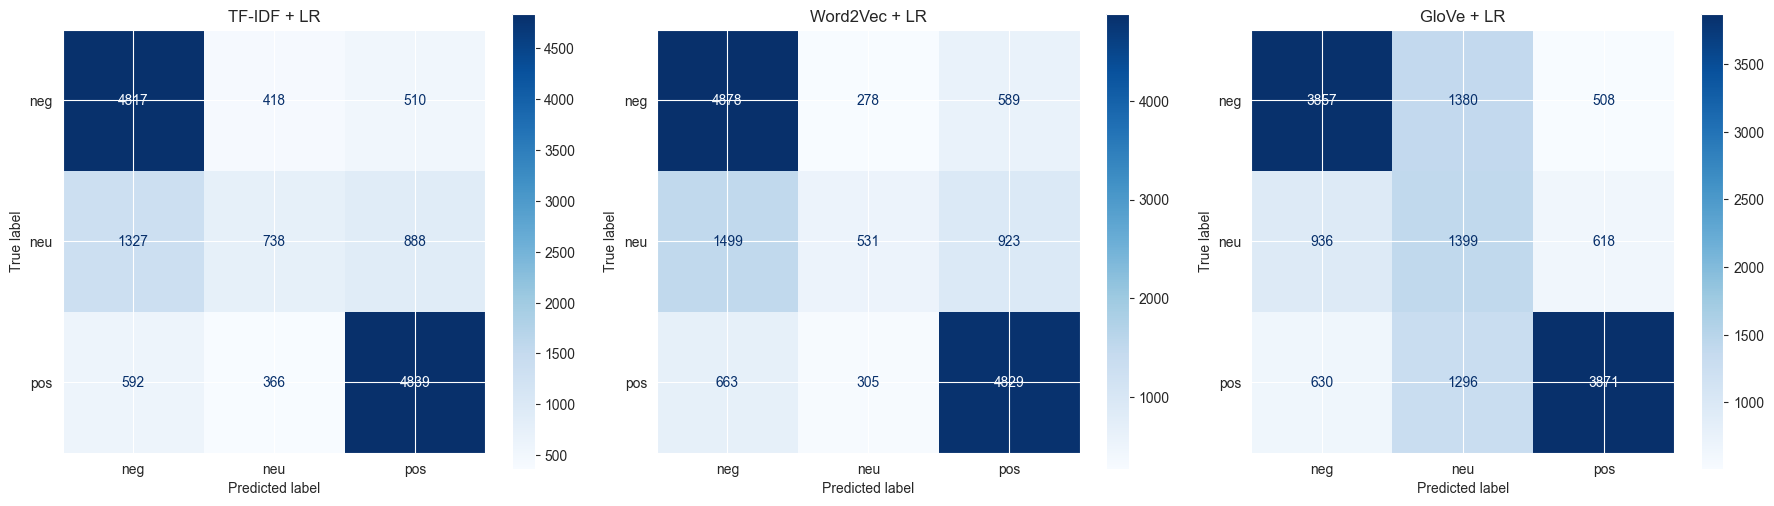

In [ ]:
# Plot confusion matrices for all three methods
methods = {
    "TF-IDF + LR": y_pred_tfidf,
    "Word2Vec + LR": y_pred_w2v,
    "GloVe + LR": y_pred_glove
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, pred) in zip(axes, methods.items()):
    cm = confusion_matrix(y_test, pred, labels=['neg', 'neu', 'pos'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['neg', 'neu', 'pos'])
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(name)
plt.tight_layout()
plt.show()

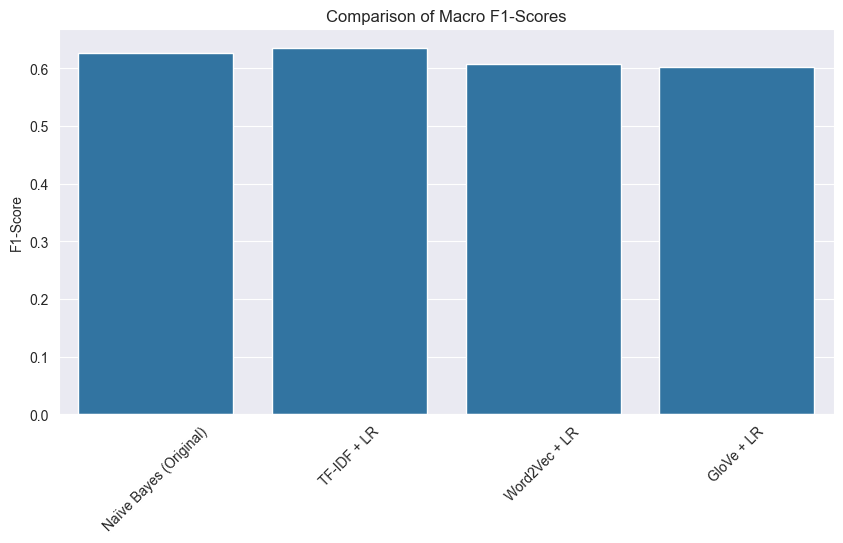

In [ ]:
# Compare F1-scores across methods
results = {
    "Naïve Bayes (Original)": classification_report(y_test, y_pred, output_dict=True),
    "TF-IDF + LR": classification_report(y_test, y_pred_tfidf, output_dict=True),
    "Word2Vec + LR": classification_report(y_test, y_pred_w2v, output_dict=True),
    "GloVe + LR": classification_report(y_test, y_pred_glove, output_dict=True)
}

# Extract macro F1-scores
f1_scores = {
    method: report['macro avg']['f1-score']
    for method, report in results.items()
}

# Plot comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.xticks(rotation=45)
plt.title("Comparison of Macro F1-Scores")
plt.ylabel("F1-Score")
plt.show()